In [131]:
#Correlation analysis between decoding accuracy and vividness ratings across subjects

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
from statsmodels.stats.multitest import multipletests

In [3]:
#Set variables
subList=[1,3,5,6,7,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,27,28];
conditions_identity = ['FACE_IDENTITY', 'PLACE_IDENTITY']
conditions_nchoosek_familiarity = ['FACE_PLACE_FAMILIAR', 'FACE_PLACE_NONFAMILIAR']
conditions_nchoosek = ['FACE_PLACE', 'FACE_PLACE_FAMILIARITY', 'FACE', 'PLACE', 'FAMILIAR']
conditions_idenFam = ['FACEFAMILIAR_IDENTITY', 'PLACEFAMILIAR_IDENTITY','FACENONFAMILIAR_IDENTITY', 'PLACENONFAMILIAR_IDENTITY']
roi_list = ['V1Left', 'V1Right', 'V2Left', 'V2Right', 'FFALeft', 'FFARight', 'PPALeft', 'PPARight', 'IFGLeft', 'IFGRight', 'mPFCLeft', 'mPFCRight', 'mPrecunLeft', 'mPrecunRight', 'OFALeft', 'OFARight', 'TPJLeft', 'TPJRight', 'SPLLeft', 'SPLRight', 'aIPSLeft', 'aIPSRight']
roi = ['V1', 'V2', 'FFA', 'PPA', 'IFG', 'mPFC', 'mPrecun', 'OFA', 'TPJ', 'SPL', 'aIPS']
sheetOrder = [(1,2), (3,4), (5,6), (7,8), (9,10), (11,12), (13,14), (15,16), (17,18), (19,20), (21,22)]
pathToData_identity = r'.\regular_leaveOneRunOut\accuracyGroup_{}_sphere9_MVPA_N=23_regular_leaveOneRunOut.xls'
pathToData_nchoosek = r'.\nchoosek_leaveOneRunOut\accuracyGroup_{}_sphere9_MVPA_N=23_nchoosek_leaveOneRunOut.xls'
chance_identity = 1/4
chance_nchoosek = 1/2

In [4]:
#Load corresponding excel files as csv
d_identity = {}
d_nchoosek = {}
#Create dataset for identity decoding 
for i in conditions_identity:
    d_identity = {condition : pd.read_excel(pathToData_identity.format(condition), sheet_name=None, header=None) for condition in conditions_identity}
#Create dataset for nchoosek decoding
for i in conditions_nchoosek:
    d_nchoosek = {condition : pd.read_excel(pathToData_nchoosek.format(condition), sheet_name=None, header=None) for condition in conditions_nchoosek}
#Create dataset for nchoosek familiarity decoding
for i in conditions_nchoosek_familiarity:
    d_nchoosek_familiarity = {condition : pd.read_excel(pathToData_nchoosek.format(condition), sheet_name=None, header=None) for condition in conditions_nchoosek_familiarity}
#Create dataset for identity decoding within familiarity
for i in conditions_nchoosek:
    d_idenFam = {condition : pd.read_excel(pathToData_identity.format(condition), sheet_name=None, header=None) for condition in conditions_idenFam}

In [5]:
#load vividness ratings
vividness_ratings = pd.read_csv(r'..\..\Results\fMRI\behavioral\rs_project_vividness_ratings.csv')
vividness_ratings

,CODE,RUN,ESTIMATE,SUB01,SUB03,SUB05,SUB06,SUB07,SUB09,SUB10,...,SUB17,SUB18,SUB20,SUB21,SUB22,SUB23,SUB24,SUB25,SUB27,SUB28
0,1,1,1,3,4,4,4,3,4,4,...,4,4,1,4,3,4,4,4,4,4
1,1,1,2,3,4,4,3,4,4,4,...,4,4,1,4,3,4,4,4,4,4
2,2,1,3,3,4,4,4,4,3,4,...,3,2,0,4,3,3,3,3,4,4
3,2,1,4,2,3,4,3,4,4,4,...,4,3,1,4,3,4,3,4,4,4
4,3,1,5,4,4,3,2,4,2,4,...,3,3,1,4,3,4,3,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,9,12,3,4,4,1,3,2,2,...,3,2,3,4,3,2,3,2,4,4
140,7,9,13,3,2,3,1,3,2,2,...,3,3,4,4,2,2,3,2,3,4
141,7,9,14,3,2,3,3,2,3,3,...,3,3,3,4,2,2,2,4,0,4
142,8,9,15,3,4,3,1,0,2,3,...,2,3,4,4,3,3,3,2,0,4


In [6]:
#Compute global average vividness rating
global_vividness = vividness_ratings.mean(axis=0)
global_vividness.drop(['CODE', 'RUN', 'ESTIMATE'], inplace=True)

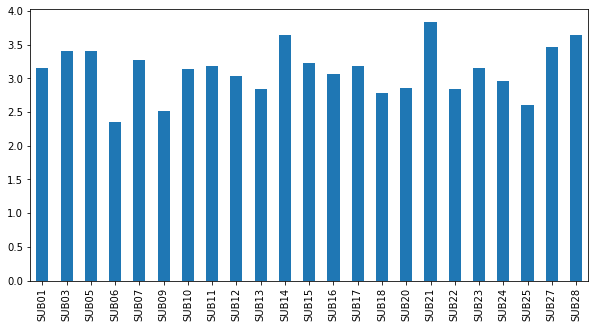

In [187]:
#Plot average vividness across subjects
fig = plt.figure(figsize=(10,5))
global_vividness.plot.bar()

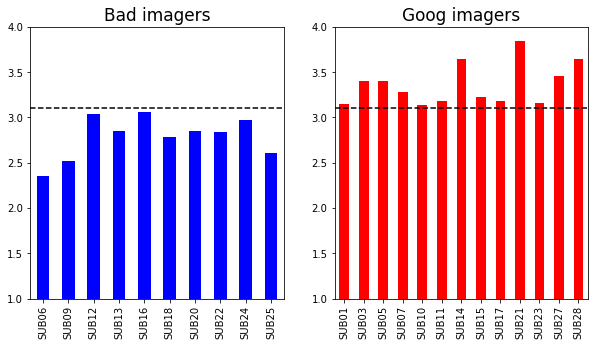

In [185]:
#Plot good and bad imagers group
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1)
ax = global_vividness[global_vividness <= 3.1].plot.bar(color='blue')
ax.set_ylim(1,4)
ax.axhline(3.1, ls='--', color = 'black')
ax.set_title('Bad imagers', fontsize = 17)
ax=fig.add_subplot(1,2,2)
ax = global_vividness[global_vividness > 3.1].plot.bar(color='red')
ax.set_ylim(1,4)
ax.set_title('Goog imagers', fontsize = 17)
ax.axhline(3.1, ls='--', color = 'black')

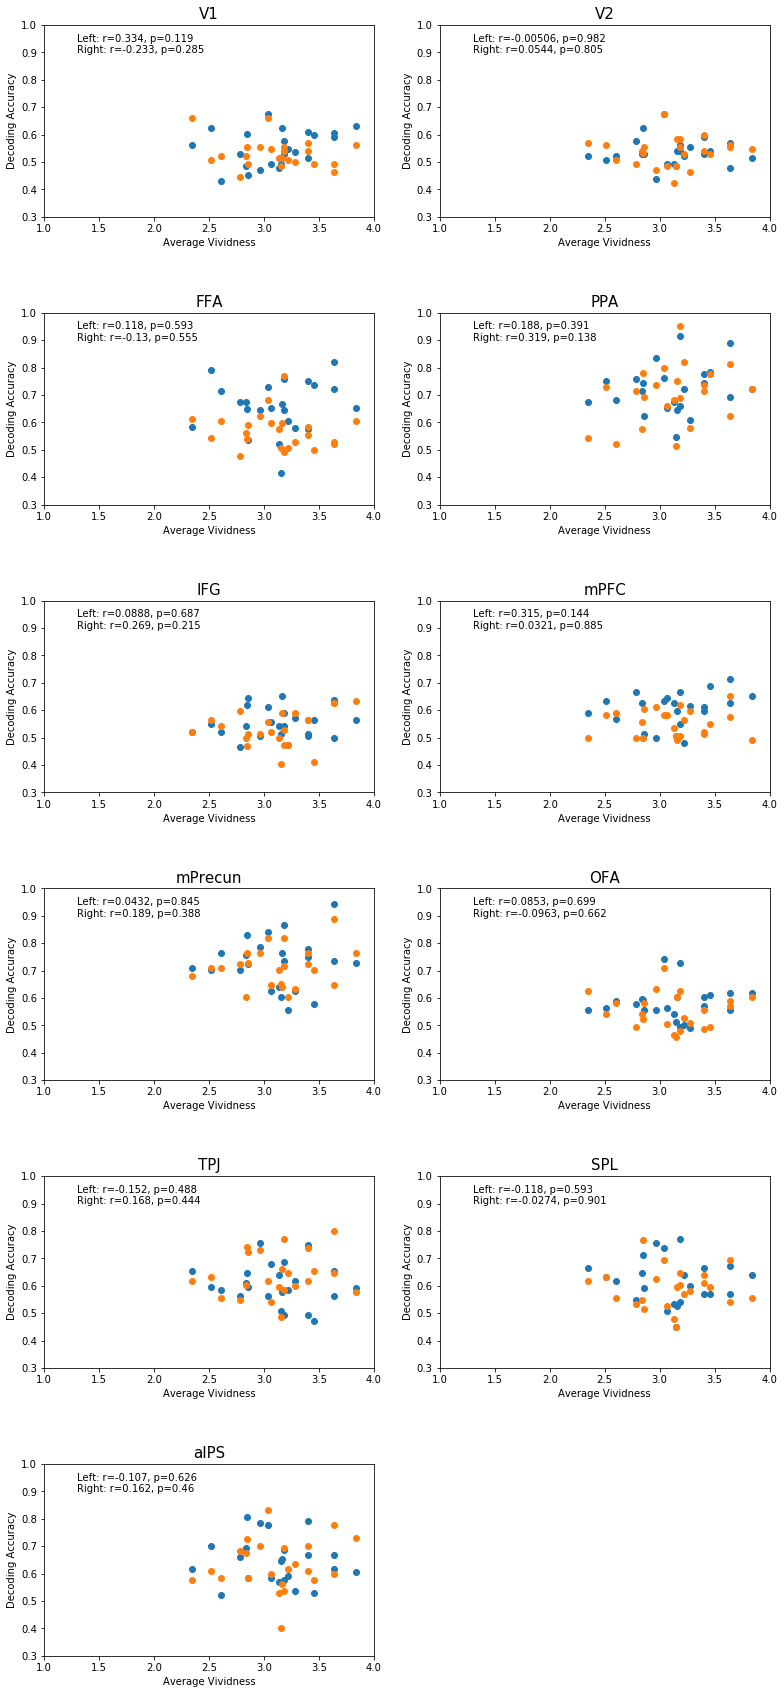

In [138]:
#Compute correlations of vividness ratings averaged across runs and conditions with decoding accuracy
#Start with face_place_familiarity, sublopts across each ROI
fig = plt.figure(figsize=(13,30))
for i in range(len(roi)):
    ax = fig.add_subplot(len(roi)//2+1, 2,i+1)
    sheet = 'Sheet{}'
    decoding_data_left = [d_nchoosek['FACE_PLACE_FAMILIARITY'][sheet.format(sheetOrder[i][0])][0]]
    decoding_data_right = [d_nchoosek['FACE_PLACE_FAMILIARITY'][sheet.format(sheetOrder[i][1])][0]]
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_left)) 
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_right))
    #Compute linear correlation
    corrLeft = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_left)[0,:])
    corrRight = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_right)[0,:])
    corr_text = 'Left: r={:.3}, p={:.3}\nRight: r={:.3}, p={:.3}'
    plt.text(0.1, 0.9, corr_text.format(corrLeft[0], corrLeft[1], corrRight[0], corrRight[1]), ha='left', va='center', transform=ax.transAxes)
    plt.ylim(0.3, 1)
    plt.xlim(1,4)
    plt.title(roi[i], fontsize=15)
    plt.xlabel('Average Vividness')
    plt.ylabel('Decoding Accuracy')
fig.subplots_adjust(hspace=0.5)

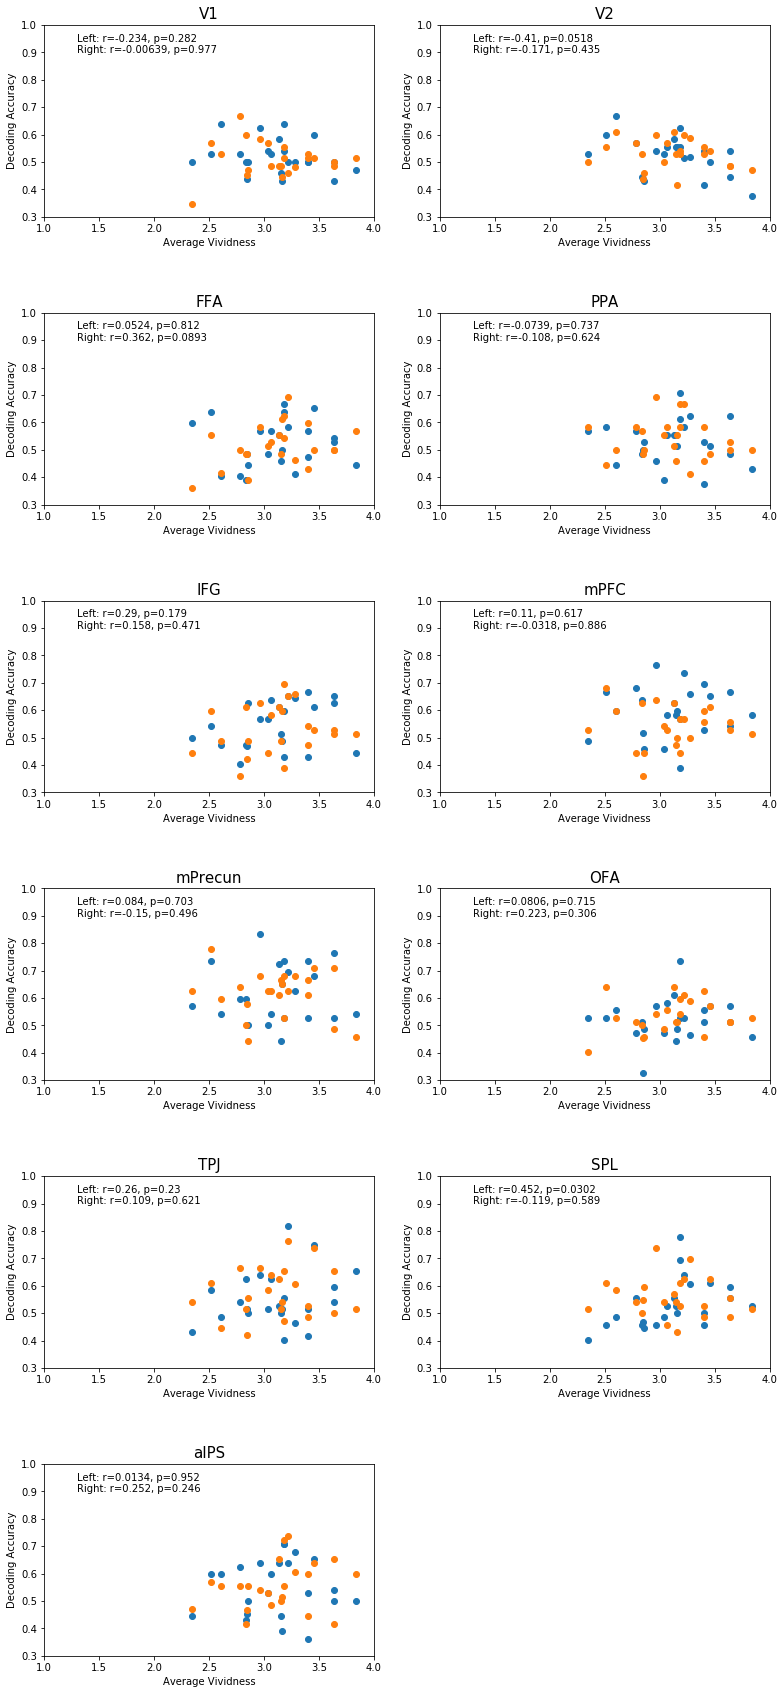

In [139]:
#Compute correlations of vividness ratings averaged across runs and conditions with decoding accuracy
#Start with face_place_familiarity, sublopts across each ROI
fig = plt.figure(figsize=(13,30))
for i in range(len(roi)):
    ax = fig.add_subplot(len(roi)//2+1, 2,i+1)
    sheet = 'Sheet{}'
    decoding_data_left = [d_nchoosek['FACE'][sheet.format(sheetOrder[i][0])][0]]
    decoding_data_right = [d_nchoosek['FACE'][sheet.format(sheetOrder[i][1])][0]]
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_left)) 
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_right))
    #Compute linear correlation
    corrLeft = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_left)[0,:])
    corrRight = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_right)[0,:])
    corr_text = 'Left: r={:.3}, p={:.3}\nRight: r={:.3}, p={:.3}'
    plt.text(0.1, 0.9, corr_text.format(corrLeft[0], corrLeft[1], corrRight[0], corrRight[1]), ha='left', va='center', transform=ax.transAxes)
    plt.ylim(0.3, 1)
    plt.xlim(1,4)
    plt.title(roi[i], fontsize=15)
    plt.xlabel('Average Vividness')
    plt.ylabel('Decoding Accuracy')
fig.subplots_adjust(hspace=0.5)

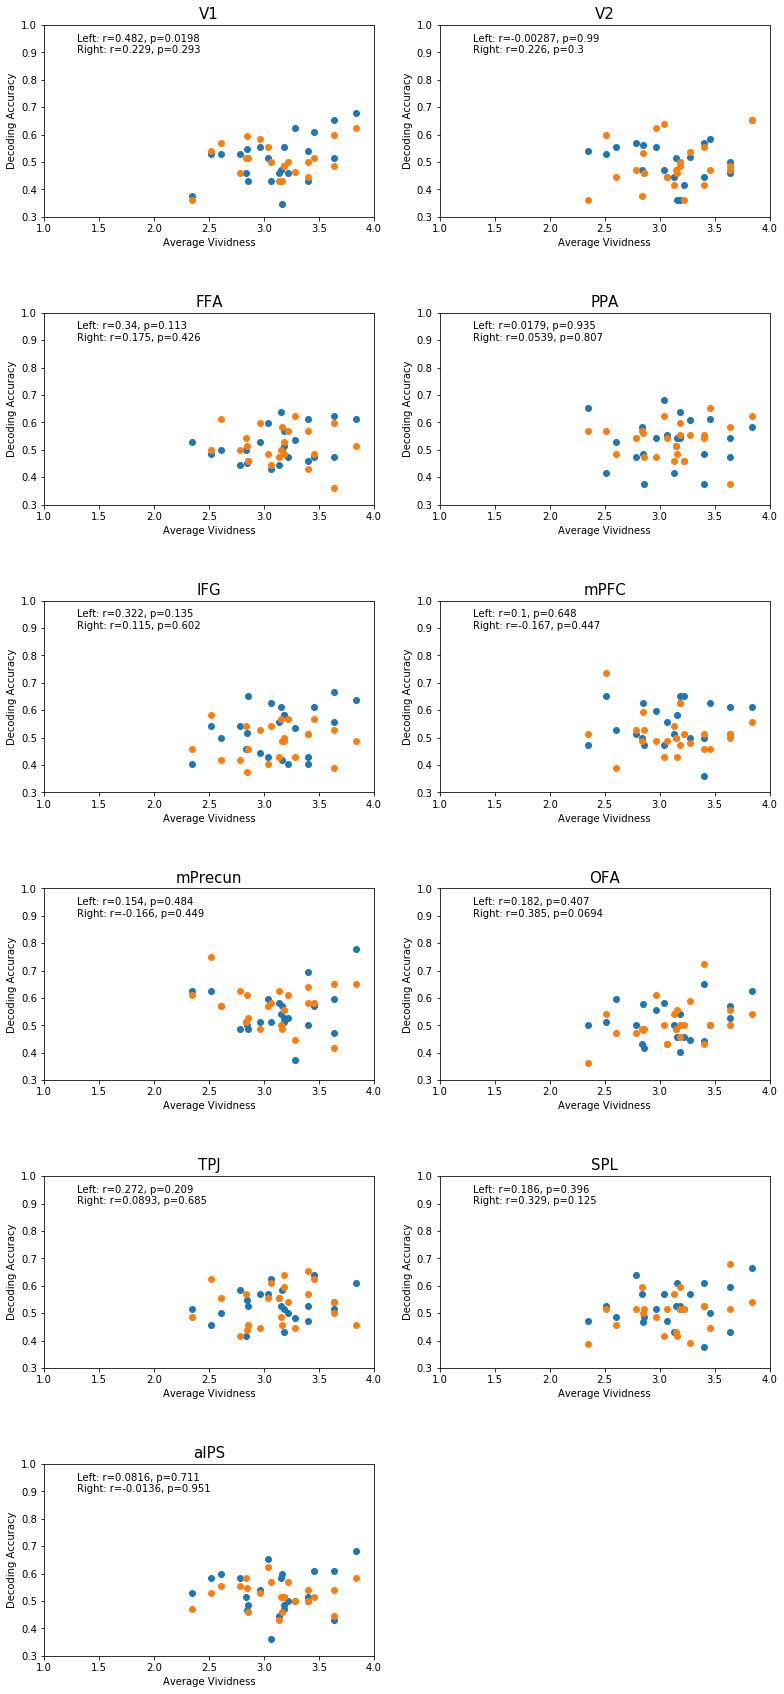

In [140]:
#Compute correlations of vividness ratings averaged across runs and conditions with decoding accuracy
#Start with face_place_familiarity, sublopts across each ROI
fig = plt.figure(figsize=(13,30))
for i in range(len(roi)):
    ax = fig.add_subplot(len(roi)//2+1, 2,i+1)
    sheet = 'Sheet{}'
    decoding_data_left = [d_nchoosek['PLACE'][sheet.format(sheetOrder[i][0])][0]]
    decoding_data_right = [d_nchoosek['PLACE'][sheet.format(sheetOrder[i][1])][0]]
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_left)) 
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_right))
    #Compute linear correlation
    corrLeft = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_left)[0,:])
    corrRight = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_right)[0,:])
    corr_text = 'Left: r={:.3}, p={:.3}\nRight: r={:.3}, p={:.3}'
    plt.text(0.1, 0.9, corr_text.format(corrLeft[0], corrLeft[1], corrRight[0], corrRight[1]), ha='left', va='center', transform=ax.transAxes)
    plt.ylim(0.3, 1)
    plt.xlim(1,4)
    plt.title(roi[i], fontsize=15)
    plt.xlabel('Average Vividness')
    plt.ylabel('Decoding Accuracy')
fig.subplots_adjust(hspace=0.5)

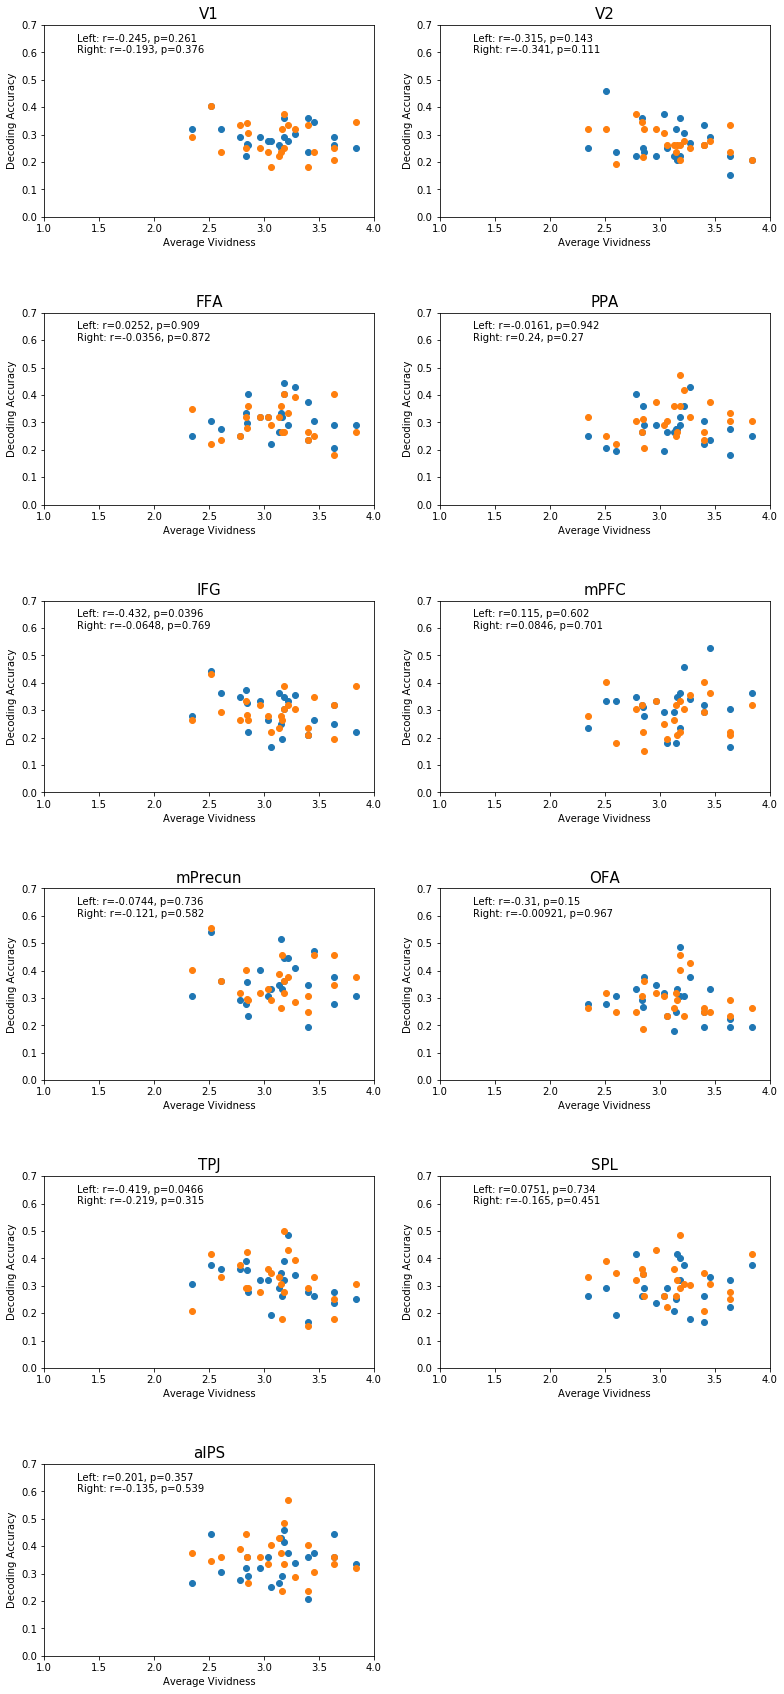

In [141]:
#Compute correlations of vividness ratings averaged across runs and conditions with decoding accuracy
#Start with face_place_familiarity, sublopts across each ROI
fig = plt.figure(figsize=(13,30))
for i in range(len(roi)):
    ax = fig.add_subplot(len(roi)//2+1, 2,i+1)
    sheet = 'Sheet{}'
    decoding_data_left = [d_identity['FACE_IDENTITY'][sheet.format(sheetOrder[i][0])][0]]
    decoding_data_right = [d_identity['FACE_IDENTITY'][sheet.format(sheetOrder[i][1])][0]]
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_left)) 
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_right))
    #Compute linear correlation
    corrLeft = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_left)[0,:])
    corrRight = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_right)[0,:])
    corr_text = 'Left: r={:.3}, p={:.3}\nRight: r={:.3}, p={:.3}'
    plt.text(0.1, 0.9, corr_text.format(corrLeft[0], corrLeft[1], corrRight[0], corrRight[1]), ha='left', va='center', transform=ax.transAxes)
    plt.ylim(0, 0.7)
    plt.xlim(1,4)
    plt.title(roi[i], fontsize=15)
    plt.xlabel('Average Vividness')
    plt.ylabel('Decoding Accuracy')
fig.subplots_adjust(hspace=0.5)

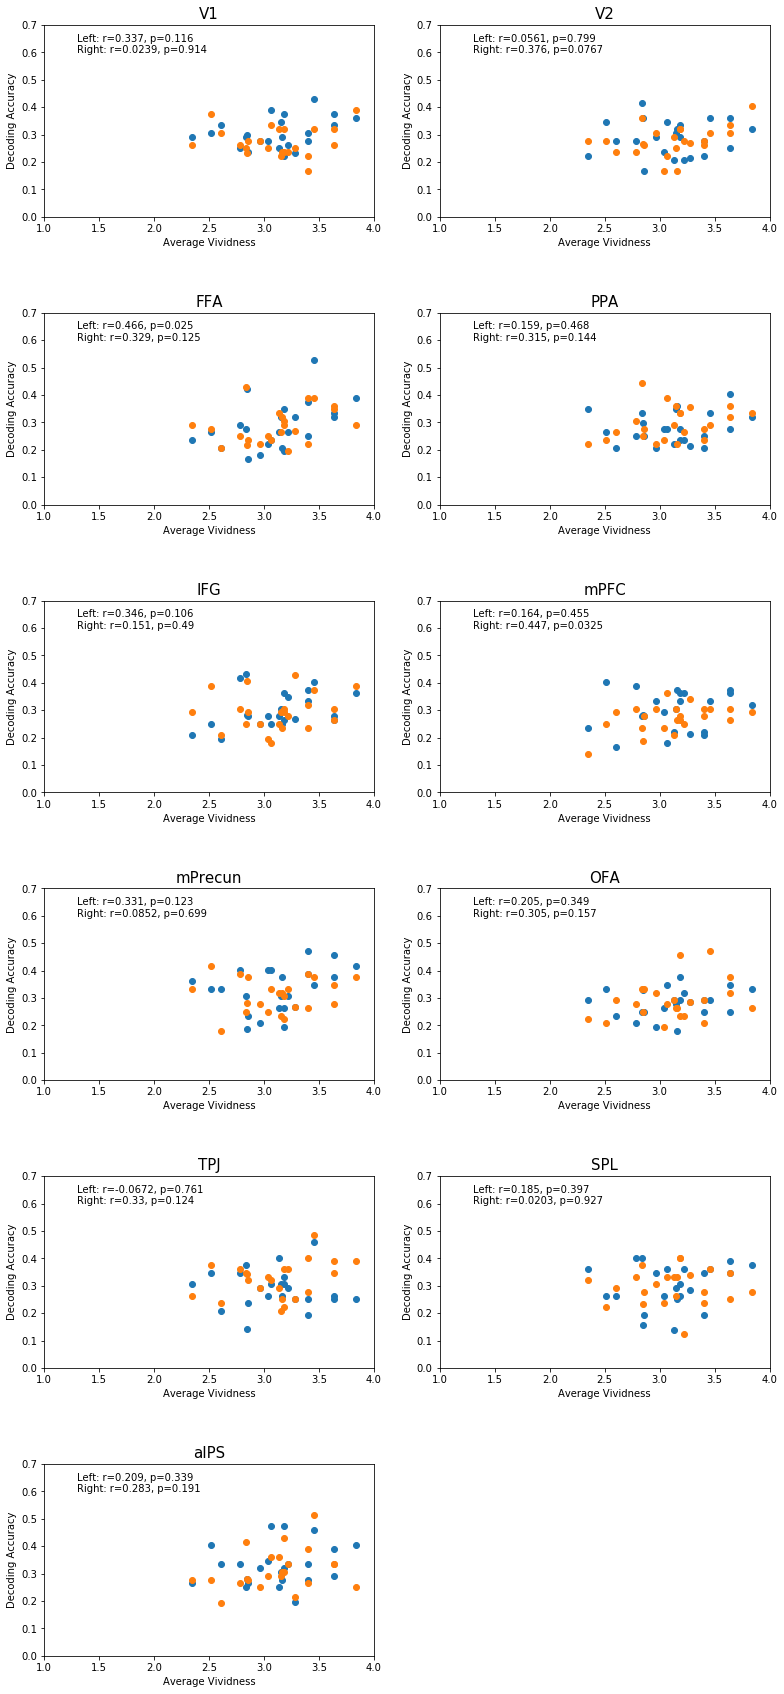

In [142]:
#Compute correlations of vividness ratings averaged across runs and conditions with decoding accuracy
#Start with face_place_familiarity, sublopts across each ROI
fig = plt.figure(figsize=(13,30))
for i in range(len(roi)):
    ax = fig.add_subplot(len(roi)//2+1, 2,i+1)
    sheet = 'Sheet{}'
    decoding_data_left = [d_identity['PLACE_IDENTITY'][sheet.format(sheetOrder[i][0])][0]]
    decoding_data_right = [d_identity['PLACE_IDENTITY'][sheet.format(sheetOrder[i][1])][0]]
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_left)) 
    ax.scatter(x=np.array(global_vividness), y=np.array(decoding_data_right))
    #Compute linear correlation
    corrLeft = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_left)[0,:])
    corrRight = stats.pearsonr(np.array(global_vividness), np.array(decoding_data_right)[0,:])
    corr_text = 'Left: r={:.3}, p={:.3}\nRight: r={:.3}, p={:.3}'
    plt.text(0.1, 0.9, corr_text.format(corrLeft[0], corrLeft[1], corrRight[0], corrRight[1]), ha='left', va='center', transform=ax.transAxes)
    plt.ylim(0, 0.7)
    plt.xlim(1,4)
    plt.title(roi[i], fontsize=15)
    plt.xlabel('Average Vividness')
    plt.ylabel('Decoding Accuracy')
fig.subplots_adjust(hspace=0.5)

In [5]:
vividness_ratings

,CODE,RUN,ESTIMATE,SUB01,SUB03,SUB05,SUB06,SUB07,SUB09,SUB10,...,SUB17,SUB18,SUB20,SUB21,SUB22,SUB23,SUB24,SUB25,SUB27,SUB28
0,1,1,1,3,4,4,4,3,4,4,...,4,4,1,4,3,4,4,4,4,4
1,1,1,2,3,4,4,3,4,4,4,...,4,4,1,4,3,4,4,4,4,4
2,2,1,3,3,4,4,4,4,3,4,...,3,2,0,4,3,3,3,3,4,4
3,2,1,4,2,3,4,3,4,4,4,...,4,3,1,4,3,4,3,4,4,4
4,3,1,5,4,4,3,2,4,2,4,...,3,3,1,4,3,4,3,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,6,9,12,3,4,4,1,3,2,2,...,3,2,3,4,3,2,3,2,4,4
140,7,9,13,3,2,3,1,3,2,2,...,3,3,4,4,2,2,3,2,3,4
141,7,9,14,3,2,3,3,2,3,3,...,3,3,3,4,2,2,2,4,0,4
142,8,9,15,3,4,3,1,0,2,3,...,2,3,4,4,3,3,3,2,0,4


In [6]:
vividness_identity = vividness_ratings.copy()
#Remove values for runs excluded in sub 7 and 13
vividness_identity.loc[vividness_identity['RUN'] == 8, 'SUB07'] = np.nan
vividness_identity.loc[vividness_identity['RUN'] == 9, 'SUB07'] = np.nan
vividness_identity.loc[vividness_identity['RUN'] == 3, 'SUB13'] = np.nan

In [9]:
vividness_identity_faces = vividness_identity.query('CODE == 1 or CODE == 2 or CODE == 5 or CODE == 6').mean(axis = 0, skipna = True)
vividness_identity_places = vividness_identity.query('CODE == 3 or CODE == 4 or CODE == 7 or CODE == 8').mean(axis = 0, skipna = True)
vividness_identity_faces.drop(['CODE', 'RUN', 'ESTIMATE'], inplace=True)
vividness_identity_places.drop(['CODE', 'RUN', 'ESTIMATE'], inplace=True)

In [17]:
#Compute correlation between decoding accuracy and vividness for Faces and Places, identity decoding
correlation_identity = pd.DataFrame()
correlation_identity_p = pd.DataFrame()
correlation_identity['faces_left'] = np.nan
correlation_identity['faces_right'] = np.nan
correlation_identity['places_left'] = np.nan
correlation_identity['places_right'] = np.nan
correlation_identity_p['faces_left'] = np.nan
correlation_identity_p['faces_right'] = np.nan
correlation_identity_p['places_left'] = np.nan
correlation_identity_p['places_right'] = np.nan
for i in range(len(roi)):
    sheet = 'Sheet{}'
    decoding_faces_left = [d_identity['FACE_IDENTITY'][sheet.format(sheetOrder[i][0])][0]]
    decoding_faces_right = [d_identity['FACE_IDENTITY'][sheet.format(sheetOrder[i][1])][0]]
    decoding_places_left = [d_identity['PLACE_IDENTITY'][sheet.format(sheetOrder[i][0])][0]]
    decoding_places_right = [d_identity['PLACE_IDENTITY'][sheet.format(sheetOrder[i][1])][0]]
    #Compute linear correlation
    corrLeft_Face = stats.pearsonr(np.array(vividness_identity_faces), np.array(decoding_faces_left)[0,:])
    corrRight_Face = stats.pearsonr(np.array(vividness_identity_faces), np.array(decoding_faces_right)[0,:])
    corrLeft_Place = stats.pearsonr(np.array(vividness_identity_places), np.array(decoding_places_left)[0,:])
    corrRight_Place = stats.pearsonr(np.array(vividness_identity_places), np.array(decoding_places_right)[0,:])
    #Add values to df
    correlation_identity.at[i, 'faces_left'] = corrLeft_Face[0]
    correlation_identity.at[i, 'faces_right'] = corrRight_Face[0]
    correlation_identity.at[i, 'places_left'] = corrLeft_Place[0]
    correlation_identity.at[i, 'places_right'] = corrRight_Place[0]
    correlation_identity_p.at[i, 'faces_left'] = corrLeft_Face[1]
    correlation_identity_p.at[i, 'faces_right'] = corrRight_Face[1]
    correlation_identity_p.at[i, 'places_left'] = corrLeft_Place[1]
    correlation_identity_p.at[i, 'places_right'] = corrRight_Place[1]
correlation_identity['ROI'] = roi
correlation_identity_p['ROI'] = roi
correlation_identity.to_csv('correlation_identity.csv', index = False)
correlation_identity_p.to_csv('correlation_identity_p.csv', index = False)

In [18]:
#Compute correlation between decoding accuracy and vividness for Faces and Places, familiarity decoding
correlation_familiarity = pd.DataFrame()
correlation_familiarity_p = pd.DataFrame()
correlation_familiarity['faces_left'] = np.nan
correlation_familiarity['faces_right'] = np.nan
correlation_familiarity['places_left'] = np.nan
correlation_familiarity['places_right'] = np.nan
correlation_familiarity_p['faces_left'] = np.nan
correlation_familiarity_p['faces_right'] = np.nan
correlation_familiarity_p['places_left'] = np.nan
correlation_familiarity_p['places_right'] = np.nan
for i in range(len(roi)):
    sheet = 'Sheet{}'
    decoding_faces_left = [d_nchoosek['FACE'][sheet.format(sheetOrder[i][0])][0]]
    decoding_faces_right = [d_nchoosek['FACE'][sheet.format(sheetOrder[i][1])][0]]
    decoding_places_left = [d_nchoosek['PLACE'][sheet.format(sheetOrder[i][0])][0]]
    decoding_places_right = [d_nchoosek['PLACE'][sheet.format(sheetOrder[i][1])][0]]
    #Compute linear correlation
    corrLeft_Face = stats.pearsonr(np.array(vividness_identity_faces), np.array(decoding_faces_left)[0,:])
    corrRight_Face = stats.pearsonr(np.array(vividness_identity_faces), np.array(decoding_faces_right)[0,:])
    corrLeft_Place = stats.pearsonr(np.array(vividness_identity_places), np.array(decoding_places_left)[0,:])
    corrRight_Place = stats.pearsonr(np.array(vividness_identity_places), np.array(decoding_places_right)[0,:])
    #Add values to df
    correlation_familiarity.at[i, 'faces_left'] = corrLeft_Face[0]
    correlation_familiarity.at[i, 'faces_right'] = corrRight_Face[0]
    correlation_familiarity.at[i, 'places_left'] = corrLeft_Place[0]
    correlation_familiarity.at[i, 'places_right'] = corrRight_Place[0]
    correlation_familiarity_p.at[i, 'faces_left'] = corrLeft_Face[1]
    correlation_familiarity_p.at[i, 'faces_right'] = corrRight_Face[1]
    correlation_familiarity_p.at[i, 'places_left'] = corrLeft_Place[1]
    correlation_familiarity_p.at[i, 'places_right'] = corrRight_Place[1]
correlation_familiarity['ROI'] = roi
correlation_familiarity_p['ROI'] = roi
correlation_familiarity.to_csv('correlation_familiarity.csv', index = False)
correlation_familiarity_p.to_csv('correlation_familiarity_p.csv', index = False)

In [25]:
#Compute correlation between decoding accuracy and vividness for Faces and Places, category decoding
correlation_category = pd.DataFrame()
correlation_category_p = pd.DataFrame()
correlation_category['left'] = np.nan
correlation_category['right'] = np.nan
correlation_category_p['left'] = np.nan
correlation_category_p['right'] = np.nan
for i in range(len(roi)):
    sheet = 'Sheet{}'
    decoding_left = [d_nchoosek['FACE_PLACE_FAMILIARITY'][sheet.format(sheetOrder[i][0])][0]]
    decoding_right = [d_nchoosek['FACE_PLACE_FAMILIARITY'][sheet.format(sheetOrder[i][1])][0]]
    #Compute linear correlation
    corrLeft = stats.pearsonr(np.array(vividness_identity.mean(axis=0).drop(['CODE', 'RUN', 'ESTIMATE'])), np.array(decoding_left)[0,:])
    corrRight = stats.pearsonr(np.array(vividness_identity.mean(axis=0).drop(['CODE', 'RUN', 'ESTIMATE'])), np.array(decoding_right)[0,:])
    #Add values to df
    correlation_category.at[i, 'left'] = corrLeft[0]
    correlation_category.at[i, 'right'] = corrRight[0]
    correlation_category_p.at[i, 'left'] = corrLeft[1]
    correlation_category_p.at[i, 'right'] = corrRight[1]
correlation_category['ROI'] = roi
correlation_category_p['ROI'] = roi
correlation_category.to_csv('correlation_category.csv', index = False)
correlation_category_p.to_csv('correlation_category_p.csv', index = False)